In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import interpolate
from astropy.table import Table, Column, vstack, join

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

from jianbing import hsc
from jianbing import utils
from jianbing import catalog

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Design TopN bins

- Here we design the TopN bins used in our analysis:
    - We want 4 bins in total
    - The bins are based on the $\lambda$ richness of `redMaPPer` clusters.
        - This is because our stellar mass catalog misses a small fraction of massive galaxies due to failed 1-D profile extraction. But `redMaPPer` richness selection should not be bothered by that. 
        - So, in principle, the "effective" survey area for our stellar mass sample should be a few percents smaller than the `redMaPPer` and `CAMIRA` ones. But this does not affect any of our results.
    - The bins are designed to ensure there are enough number of objects in each bin to achieve sufficient S/N of $\Delta\Sigma$ profiles.
    
- After a few attempts, we find the following 4 bins are good choices:
    1. Bin 1: $35 < \lambda < 110$
    2. Bin 2: $20 < \lambda < 35$
    3. Bin 3: $10 < \lambda < 20$
    4. Bin 4: $6 < \lambda < 10$

In [7]:
# Location of TopN test directory
topn_dir = "/Volumes/astro1/hsc/jianbing"

jb_dir = "/Users/song/Dropbox/work/submit/jianbing/"

In [52]:
# Pre-compute results using medium photo-z quality cut
s16a_precompute_med = os.path.join(topn_dir, 'topn_public_s16a_medium_precompute.hdf5')

# Pre-compute results for each individual samples 

# HSC massive galaxies
hsc_cat = Table.read(s16a_precompute_med, path='hsc')
hsc_use = hsc_cat

# S16A HSC redMaPPer catalog
redm = Table.read(s16a_precompute_med, path='redm_hsc_specz')
redm_use = redm

In [53]:
# Redshift limits and survey volume
z_low, z_upp = 0.19, 0.52

s16a_vol = utils.get_volume(hsc.A_S16A, z_low, z_upp)
s16a_vol_mpdl2 = utils.get_volume(hsc.A_S16A, z_low, z_upp, h=0.6777)

# Volume between 0.19 < z < 0.52 is 97824323.66826256 Mpc^3
# Volume between 0.19 < z < 0.52 is 107802421.71232714 Mpc^3


### MDPL2 halo catalog

In [54]:
# Halo mass catalog from MDPL2
mdpl2_use = np.load(os.path.join(topn_dir, 'mdpl2_hlist_0.73330_reduced_logmvir_13.0.npy'))
print(len(mdpl2_use))

logm_vir = np.log10(mdpl2_use['Mvir'])

403126


In [55]:
mdpl2_size, mdpl2_h = 1000., 0.6777
mdpl2_vol = (mdpl2_size / mdpl2_h) ** 3

vol_ratio = mdpl2_vol / s16a_vol_mpdl2
print(vol_ratio)

29.802934339014516


#### Halo mass functions of MDPL2 Halo

In [56]:
mdpl2_hmf = Table.read(os.path.join(jb_dir, 'data', 'simulation', 'mdpl2_hmf.fits'))

mdpl2_cen = mdpl2_hmf['log_mh'][:-2]
mdpl2_phi_low, mdpl2_phi_upp = mdpl2_hmf['phi_low'][:-2], mdpl2_hmf['phi_upp'][:-2]
mdpl2_phi_avg = mdpl2_hmf['phi'][:-2]

mdpl2_inter = interpolate.interp1d(
    mdpl2_cen, np.log10(mdpl2_phi_avg), fill_value='extrapolate', kind='linear')

#### Number of objects in each bin based on redMaPPer clusters

In [57]:
lambda_low, lambda_upp = 5, 130
lambda_0, lambda_1, lambda_2, lambda_3, lambda_4 = 110, 35, 20, 10, 6

num_0, rho_0, err_0 = catalog.get_number_density(redm_use, lambda_0, lambda_upp)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(num_0, rho_0, err_0))

num_1, rho_1, err_1 = catalog.get_number_density(redm_use, lambda_1, lambda_0)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(num_1, rho_1, err_1))

num_2, rho_2, err_2 = catalog.get_number_density(redm_use, lambda_2, lambda_1)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(num_2, rho_2, err_2))

num_3, rho_3, err_3 = catalog.get_number_density(redm_use, lambda_3, lambda_2)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(num_3, rho_3, err_3))

num_4, rho_4, err_4 = catalog.get_number_density(redm_use, lambda_4, lambda_3)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(num_4, rho_4, err_4))

N:     1   n:  0.01022E-6   n_err: 0.01022E-6
N:    52   n:  0.53157E-6   n_err: 0.07371E-6
N:   196   n:  2.00359E-6   n_err: 0.14311E-6
N:   660   n:  6.74679E-6   n_err: 0.26262E-6
N:  1159   n: 11.84777E-6   n_err: 0.34801E-6


#### Cumulative number and numbder density

In [58]:
ntot_1, n_1, err_1 = catalog.get_number_density(redm_use, lambda_1, lambda_upp)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(ntot_1, n_1, err_1))

ntot_2, n_2, err_2 = catalog.get_number_density(redm_use, lambda_2, lambda_upp)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(ntot_2, n_2, err_2))

ntot_3, n_3, err_3 = catalog.get_number_density(redm_use, lambda_3, lambda_upp)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(ntot_3, n_3, err_3))

ntot_4, n_4, err_4 = catalog.get_number_density(redm_use, lambda_4, lambda_upp)
print("N: {:5d}   n: {:8.5f}E-6   n_err: {:7.5f}E-6".format(ntot_4, n_4, err_4))

N:    53   n:  0.54179E-6   n_err: 0.07442E-6
N:   249   n:  2.54538E-6   n_err: 0.16131E-6
N:   909   n:  9.29217E-6   n_err: 0.30820E-6
N:  2068   n: 21.13994E-6   n_err: 0.46487E-6


In [59]:
# Lower ranking of each bin
rank_low = [num_0, ntot_1 + 1, ntot_2 + 1, ntot_3 + 1]

# Upper ranking of each bin
rank_upp = [ntot_1, ntot_2, ntot_3, ntot_4]

# Number of object in each bin
n_obj = [num_0 + num_1, num_2, num_3, num_4]

# Number density for object in each bin
rho_bin = [rho_1 * 1e-6, rho_2 * 1e-6, rho_3 * 1e-6, rho_4 * 1e-6]

# Cumulative number density
rho_cum = [n_1  * 1e-6, n_2 * 1e-6, n_3 * 1e-6, n_4 * 1e-6]

#### Halo mass boundaries

In [60]:
# Number of MDPL2 halos in each bin
n_obj_mdpl2 = (np.asarray(n_obj) * vol_ratio).astype(int)

rank_0, rank_1 = 1, n_obj_mdpl2[0]
rank_2, rank_3 = n_obj_mdpl2[0:2].sum(), n_obj_mdpl2[0:3].sum()
rank_4 = n_obj_mdpl2.sum()

_, logm_vir_1, logm_vir_0 = catalog.get_mask_within_ranks(
    logm_vir, rank_0, rank_1, return_minmax=True)

_, logm_vir_2, logm_vir_1 = catalog.get_mask_within_ranks(
    logm_vir, rank_1, rank_2, return_minmax=True)

_, logm_vir_3, logm_vir_2 = catalog.get_mask_within_ranks(
    logm_vir, rank_2, rank_3, return_minmax=True)

_, logm_vir_4, logm_vir_3 = catalog.get_mask_within_ranks(
    logm_vir, rank_3, rank_4, return_minmax=True)


logm_vir_0 = 15.25
logm_vir_low = [logm_vir_0, logm_vir_1, logm_vir_2, logm_vir_3]
logm_vir_upp = [logm_vir_1, logm_vir_2, logm_vir_3, logm_vir_4]

phi_mdpl2_0 = mdpl2_inter(logm_vir_0)
phi_mdpl2_1 = mdpl2_inter(logm_vir_1)
phi_mdpl2_2 = mdpl2_inter(logm_vir_2)
phi_mdpl2_3 = mdpl2_inter(logm_vir_3)
phi_mdpl2_4 = mdpl2_inter(logm_vir_4)

In [61]:
logm_100 = hsc_use['logm_100']

_, m100_1, m100_0 = catalog.get_mask_within_ranks(
    logm_100, rank_low[0], rank_upp[0], return_minmax=True)

_, m100_2, m100_1 = catalog.get_mask_within_ranks(
    logm_100, rank_low[1], rank_upp[1], return_minmax=True)

_, m100_3, m100_2 = catalog.get_mask_within_ranks(
    logm_100, rank_low[2], rank_upp[2], return_minmax=True)

_, m100_4, m100_3 = catalog.get_mask_within_ranks(
    logm_100, rank_low[3], rank_upp[3], return_minmax=True)

In [62]:
m100_low, m100_upp, m100_nbin = 11.4, 12.19, 10
m100_smf = utils.mass_function_list(
    hsc_use['logm_100'], s16a_vol, m100_nbin, m100_low, m100_upp, 
    scatter=0.0, nsample=2000)

m100_bin = np.linspace(m100_low, m100_upp, m100_nbin + 1)
m100_cen = (m100_bin[1:] + m100_bin[0:-1]) / 2

m100_phi_avg = np.nanmedian(m100_smf, axis=0)
m100_phi_low = np.percentile(m100_smf, 16, axis=0)
m100_phi_upp = np.percentile(m100_smf, 84, axis=0)

m100_inter = interpolate.interp1d(
    m100_cen, np.log10(m100_phi_avg), fill_value='extrapolate', kind='linear')

phi_m100_0 = m100_inter(m100_0)
phi_m100_1 = m100_inter(m100_1)
phi_m100_2 = m100_inter(m100_2)
phi_m100_3 = m100_inter(m100_3)
phi_m100_4 = m100_inter(m100_4)

In [63]:
topn_table = Table()
topn_table['bin_id'] = [1, 2, 3, 4]
topn_table['n_obj'] = n_obj
topn_table['rank_low'] = rank_low
topn_table['rank_upp'] = rank_upp
topn_table['index_low'] = np.asarray(rank_low) - 1
topn_table['index_upp'] = np.asarray(rank_upp) - 1
topn_table['rho_bin'] = rho_bin
topn_table['rho_cum'] = rho_cum
topn_table['lambda_redm_upp'] = [lambda_0, lambda_1, lambda_2, lambda_3]
topn_table['lambda_redm_low'] = [lambda_1, lambda_2, lambda_3, lambda_4]
topn_table['logmh_mdpl2_upp'] = [logm_vir_0, logm_vir_1, logm_vir_2, logm_vir_3]
topn_table['logmh_mdpl2_low'] = [logm_vir_1, logm_vir_2, logm_vir_3, logm_vir_4]
topn_table['logm_100_upp'] = [m100_0, m100_1, m100_2, m100_3]
topn_table['logm_100_low'] = [m100_1, m100_2, m100_3, m100_4]

# Save the table
topn_table.write(os.path.join(jb_dir, 'data', 'bins', 'topn_bins.fits'), overwrite=True)

### Visualize the bins

In [64]:
loglam = np.log(redm_use['lambda'])
lam_low, lam_upp, lam_nbin = np.log(lambda_low), np.log(lambda_upp), 8

lam_func = utils.mass_function_list(
    loglam, s16a_vol, lam_nbin, lam_low, lam_upp, scatter=0.0, nsample=2000)

lam_bin = np.linspace(lam_low, lam_upp, lam_nbin + 1)
lam_cen = (lam_bin[1:] + lam_bin[0:-1]) / 2

lam_phi_avg = np.nanmedian(lam_func, axis=0)
lam_phi_low = np.percentile(lam_func, 16, axis=0)
lam_phi_upp = np.percentile(lam_func, 84, axis=0)

lam_inter = interpolate.interp1d(
    lam_cen, np.log10(lam_phi_avg), fill_value='extrapolate', kind='linear')

lam_0 = np.log(lambda_0)
lam_1 = np.log(lambda_1)
lam_2 = np.log(lambda_2)
lam_3 = np.log(lambda_3)
lam_4 = np.log(lambda_4)

phi_lam_0 = lam_inter(np.log(lambda_0))
phi_lam_1 = lam_inter(np.log(lambda_1))
phi_lam_2 = lam_inter(np.log(lambda_2))
phi_lam_3 = lam_inter(np.log(lambda_3))
phi_lam_4 = lam_inter(np.log(lambda_4))

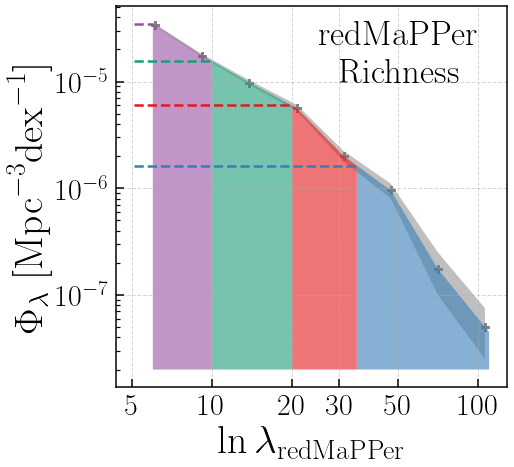

In [65]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# Richness function
ax1.fill_between(np.exp(lam_cen), lam_phi_low, lam_phi_upp, alpha=0.5, 
                 facecolor='grey', label=r'__no_label', zorder=0)
ax1.scatter(np.exp(lam_cen), lam_phi_avg, marker='P', c='grey', s=50, label='__no_label')

# Bin 1
lam_bin1 = np.linspace(lam_1, lam_0, 500)
ax1.fill_between(np.exp(lam_bin1), lam_bin1 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin1), 
                 alpha=0.6, facecolor=color_bins[0], label=r'$\rm Bin\ 1$')
ax1.plot(np.asarray([5.1, np.exp(lam_1)]), np.asarray([10.0 ** phi_lam_1, 10.0 ** phi_lam_1]), 
         linewidth=2.5, linestyle='--', color=color_bins[0])

# Bin 2
lam_bin2 = np.linspace(lam_2, lam_1, 500)
ax1.fill_between(np.exp(lam_bin2), lam_bin2 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin2), 
                 alpha=0.6, facecolor=color_bins[1], label=r'$\rm Bin\ 2$')
ax1.plot(np.asarray([5.1, np.exp(lam_2)]), np.asarray([10.0 ** phi_lam_2, 10.0 ** phi_lam_2]), 
         linewidth=2.5, linestyle='--', color=color_bins[1])

# Bin 3
lam_bin3 = np.linspace(lam_3, lam_2, 500)
ax1.fill_between(np.exp(lam_bin3), lam_bin3 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin3), 
                 alpha=0.6, facecolor=color_bins[2], label=r'$\rm Bin\ 3$')
ax1.plot(np.asarray([5.1, np.exp(lam_3)]), np.asarray([10.0 ** phi_lam_3, 10.0 ** phi_lam_3]), 
         linewidth=2.5, linestyle='--', color=color_bins[2])

# Bin 4
lam_bin4 = np.linspace(lam_4, lam_3, 500)
ax1.fill_between(np.exp(lam_bin4), lam_bin4 * 0 + 2e-8, 10.0 ** lam_inter(lam_bin4), 
                 alpha=0.6, facecolor=color_bins[3], label=r'$\rm Bin\ 4$')
ax1.plot(np.asarray([5.1, np.exp(lam_4)]), np.asarray([10.0 ** phi_lam_4, 10.0 ** phi_lam_4]), 
         linewidth=2.5, linestyle='--', color=color_bins[3])

ax1.set_xscale("log", nonpositive='clip', base=np.e)
ax1.set_yscale("log", nonpositive='clip')
ax1.set_xticks([5, 10, 20, 30, 50, 100])
ax1.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

_ = ax1.set_xlabel(r'$\ln\lambda_{\rm redMaPPer}$', fontsize=40)
_ = ax1.set_ylabel((r'$\Phi_{\lambda}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=40)

_ = ax1.text(0.52, 0.9, r'$\rm redMaPPer$', fontsize=35, transform=ax1.transAxes)
_ = ax1.text(0.57, 0.8, r'$\rm Richness$', fontsize=35, transform=ax1.transAxes)

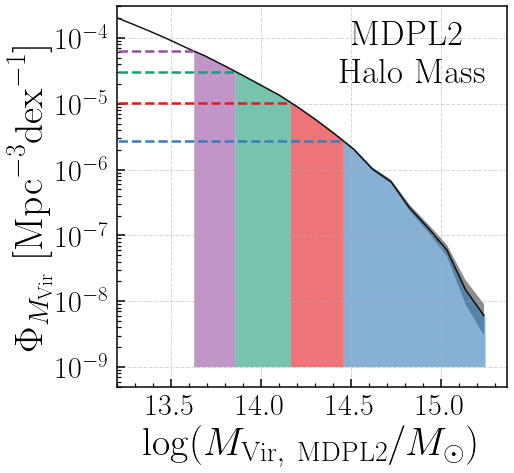

In [66]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)
ax1.set_yscale("log", nonpositive='clip')

ax1.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# HMF
ax1.plot(mdpl2_cen, mdpl2_phi_avg, c='k', alpha=0.9)
ax1.fill_between(mdpl2_cen, mdpl2_phi_low, mdpl2_phi_upp, alpha=0.9, facecolor='grey', 
                 label=r'__no_label', zorder=0)

# Bin 1
mdpl2_bin1 = np.linspace(logm_vir_low[0], logm_vir_upp[0], 1500)
ax1.fill_between(mdpl2_bin1, mdpl2_bin1 * 0 + 1e-9, 10.0 ** mdpl2_inter(mdpl2_bin1), 
                 alpha=0.6, facecolor=color_bins[0], label=r'$\rm Bin\ 1$', rasterized=True)
ax1.plot(np.asarray([12.30, logm_vir_upp[0]]), np.asarray([10.0 ** phi_mdpl2_1, 10.0 ** phi_mdpl2_1]), 
         linewidth=2.5, linestyle='--', color=color_bins[0])

# Bin 2
mdpl2_bin2 = np.linspace(logm_vir_low[1], logm_vir_upp[1], 1500)
ax1.fill_between(mdpl2_bin2, mdpl2_bin2 * 0 + 1e-9, 10.0 ** mdpl2_inter(mdpl2_bin2), 
                 alpha=0.6, facecolor=color_bins[1], label=r'$\rm Bin\ 2$', rasterized=True)
ax1.plot(np.asarray([12.30, logm_vir_upp[1]]), np.asarray([10.0 ** phi_mdpl2_2, 10.0 ** phi_mdpl2_2]), 
         linewidth=2.5, linestyle='--', color=color_bins[1])

# Bin 3
mdpl2_bin3 = np.linspace(logm_vir_low[2], logm_vir_upp[2], 1500)
ax1.fill_between(mdpl2_bin3, mdpl2_bin3 * 0 + 1e-9, 10.0 ** mdpl2_inter(mdpl2_bin3), 
                 alpha=0.6, facecolor=color_bins[2], label=r'$\rm Bin\ 3$', rasterized=True)
ax1.plot(np.asarray([12.30, logm_vir_upp[2]]), np.asarray([10.0 ** phi_mdpl2_3, 10.0 ** phi_mdpl2_3]), 
         linewidth=2.5, linestyle='--', color=color_bins[2])

# Bin 4
mdpl2_bin4 = np.linspace(logm_vir_low[3], logm_vir_upp[3], 1500)
ax1.fill_between(mdpl2_bin4, mdpl2_bin4 * 0 + 1e-9, 10.0 ** mdpl2_inter(mdpl2_bin4), 
                 alpha=0.6, facecolor=color_bins[3], label=r'$\rm Bin\ 4$', rasterized=True)
ax1.plot(np.asarray([12.30, logm_vir_upp[3]]), np.asarray([10.0 ** phi_mdpl2_4, 10.0 ** phi_mdpl2_4]), 
         linewidth=2.5, linestyle='--', color=color_bins[3])

ax1.set_xlim(13.2, 15.37)
ax1.set_ylim(5e-10, 3e-4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

_ = ax1.set_xlabel(r'$\log (M_{\rm Vir,\ \rm MDPL2}/M_{\odot})$', fontsize=40)
_ = ax1.set_ylabel((r'$\Phi_{M_{\rm Vir}}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=40)

_ = ax1.text(0.60, 0.9, r'$\rm MDPL2$', fontsize=35, transform=ax1.transAxes)
_ = ax1.text(0.57, 0.8, r'$\rm Halo\ Mass$', fontsize=35, transform=ax1.transAxes)

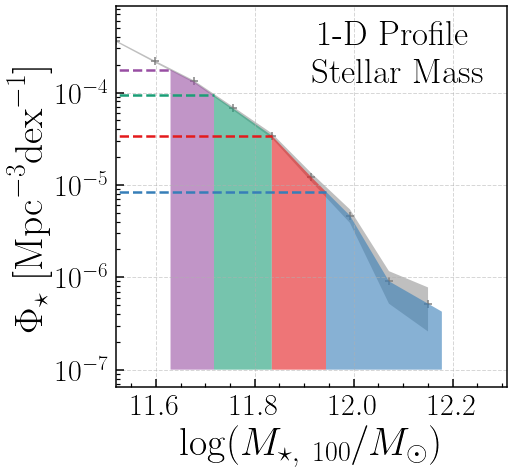

In [67]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)

ax1.set_yscale("log", nonpositive='clip')

ax1.grid(linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# SMF
ax1.fill_between(m100_cen, m100_phi_low, m100_phi_upp, alpha=0.5, facecolor='grey', 
                 label=r'__no_label', zorder=0)
ax1.scatter(m100_cen, m100_phi_avg, marker='+', c='grey',  s=50, label='__no_label')

# Bin 1
m100_bin1 = np.linspace(m100_1, m100_0, 500)
ax1.fill_between(m100_bin1, m100_bin1 * 0 + 1e-7, 10.0 ** m100_inter(m100_bin1), 
                 alpha=0.6, facecolor=color_bins[0], label=r'$\rm Bin\ 1$')
ax1.plot(np.asarray([11.50, m100_1]), np.asarray([10.0 ** phi_m100_1, 10.0 ** phi_m100_1]), 
         linewidth=2.5, linestyle='--', color=color_bins[0])

# Bin 2
m100_bin2 = np.linspace(m100_2, m100_1, 500)
ax1.fill_between(m100_bin2, m100_bin2 * 0 + 1e-7, 10.0 ** m100_inter(m100_bin2), 
                 alpha=0.6, facecolor=color_bins[1], label=r'$\rm Bin\ 2$')
ax1.plot(np.asarray([11.50, m100_2]), np.asarray([10.0 ** phi_m100_2, 10.0 ** phi_m100_2]), 
         linewidth=2.5, linestyle='--', color=color_bins[1])

# Bin 3
m100_bin3 = np.linspace(m100_3, m100_2, 500)
ax1.fill_between(m100_bin3, m100_bin3 * 0 + 1e-7, 10.0 ** m100_inter(m100_bin3), 
                 alpha=0.6, facecolor=color_bins[2], label=r'$\rm Bin\ 3$')
ax1.plot(np.asarray([11.50, m100_3]), np.asarray([10.0 ** phi_m100_3, 10.0 ** phi_m100_3]), 
         linewidth=2.5, linestyle='--', color=color_bins[2])

# Bin 4
m100_bin4 = np.linspace(m100_4, m100_3, 500)
ax1.fill_between(m100_bin4, m100_bin4 * 0 + 1e-7, 10.0 ** m100_inter(m100_bin4), 
                 alpha=0.6, facecolor=color_bins[3], label=r'$\rm Bin\ 4$')
ax1.plot(np.asarray([11.50, m100_4]), np.asarray([10.0 ** phi_m100_4, 10.0 ** phi_m100_4]), 
         linewidth=2.5, linestyle='--', color=color_bins[3])

ax1.set_xlim(11.52, 12.31)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

#ax1.legend(fontsize=25, loc='best')

_ = ax1.set_xlabel(r'$\log (M_{\star,\ \rm 100}/M_{\odot})$', fontsize=40)
_ = ax1.set_ylabel((r'$\Phi_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=40)

_ = ax1.text(0.52, 0.9, r'$\rm 1\hbox{-}D\ Profile$', fontsize=35, transform=ax1.transAxes)
_ = ax1.text(0.50, 0.8, r'$\rm Stellar\ Mass$', fontsize=35, transform=ax1.transAxes)